# Recoemndador de peliculas

## Carga de librerias 

In [1]:
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
from urllib.request import urlretrieve

## obtener datos

In [2]:
# Dataset
print("Descargando el conjunto de datos...")

urlretrieve("https://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
info = zip_ref.read('ml-100k/u.info')

print(f"Descargado! Numero de elementos descargados {info}")

Descargando el conjunto de datos...
Descargado! Numero de elementos descargados b'943 users\n1682 items\n100000 ratings\n'


In [3]:
# Cargamos los datos de los usuarios
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


Podemos ver cómo es la estructura base de nuestro conjunto de usuarios donde disponemos de rangos de edad, sexo, ocupación y código postal informado.

## Exploracion de datos

<Axes: xlabel='age', ylabel='Count'>

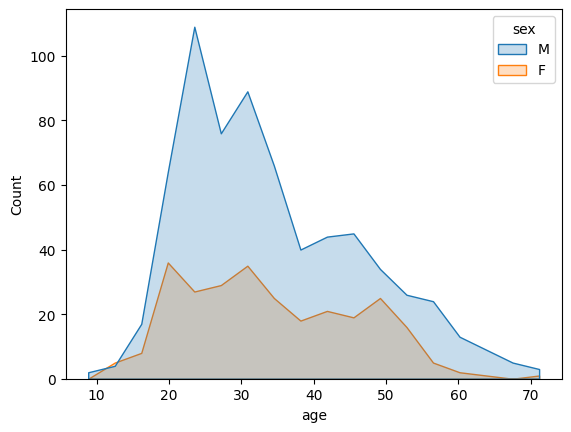

In [4]:
# Muestra ejemplo de la distribución de edad po sexo
sns.histplot(users, x="age", hue="sex", element="poly")

<Axes: xlabel='age', ylabel='occupation'>

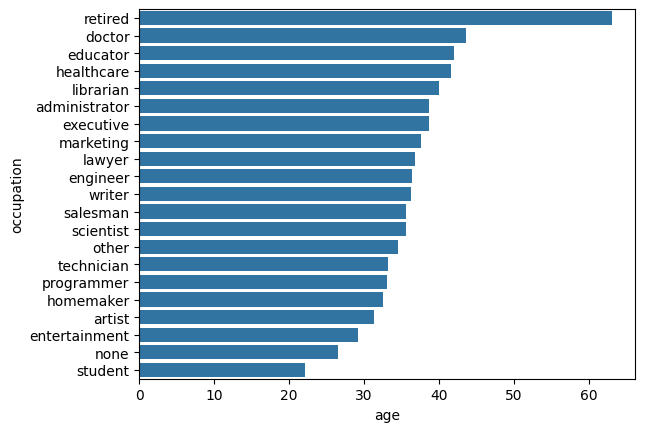

In [5]:
data = users.groupby("occupation")["age"].mean()
data = data.reset_index().sort_values("age", ascending=False)
sns.barplot(y="occupation",x="age", data=data)

In [6]:
users.groupby("occupation")["age"].count().sort_values(ascending=False)

occupation
student          196
other            105
educator          95
administrator     79
engineer          67
programmer        66
librarian         51
writer            45
executive         32
scientist         31
artist            28
technician        27
marketing         26
entertainment     18
healthcare        16
retired           14
lawyer            12
salesman          12
none               9
doctor             7
homemaker          7
Name: age, dtype: int64

In [7]:
common_users = users[users["occupation"].isin(["student", "other","educator"])]

<Axes: xlabel='age', ylabel='Count'>

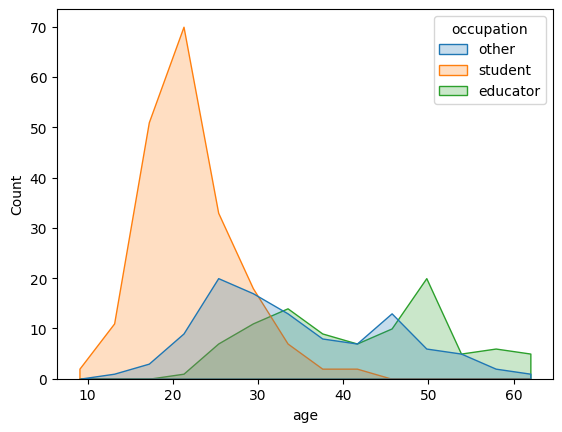

In [8]:
sns.histplot(common_users, x="age", hue="occupation", element="poly")

## Ítems (Movies)

Las películas serán para nosotros los items a recomendar a nuestros usuarios. Obtendremos los datos del conjunto base y además complementaremos aquella información que enriquezca nuestro conocimiento sobre estas pelíoculas de cara a recomendar aquellas que sean del agrado de nuestros usuarios.

In [9]:
# Cargamos las películas
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = ['movie_id', 'title', 'release_date', "video_release_date", "imdb_url"] + genre_cols
movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Obtenemos el año de la fecha de publicación
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
movies.head(10)

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1995
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1995
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
6,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1995
7,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1995
8,9,Dead Man Walking (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
9,10,Richard III (1995),22-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Richard%20III...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1996


Podemos ver que el conjunto de base ya contiene el etiquetado de los generos de cada película en formato [OneHotEncoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). Es una forma sencilla de codificar variables categoricas de forma que podamos utilizarlas de forma numérica. Ahondaremos en esto más adelante.

Veamos ahora cual es la distribución de nuestros ítems por genero.

In [10]:
df = movies[genre_cols].sum().sort_values(ascending=False)
df

Drama            725
Comedy           505
Action           251
Thriller         251
Romance          247
Adventure        135
Children         122
Crime            109
Sci-Fi           101
Horror            92
War               71
Mystery           61
Musical           56
Documentary       50
Animation         42
Western           27
Film-Noir         24
Fantasy           22
genre_unknown      2
dtype: int64

<Axes: >

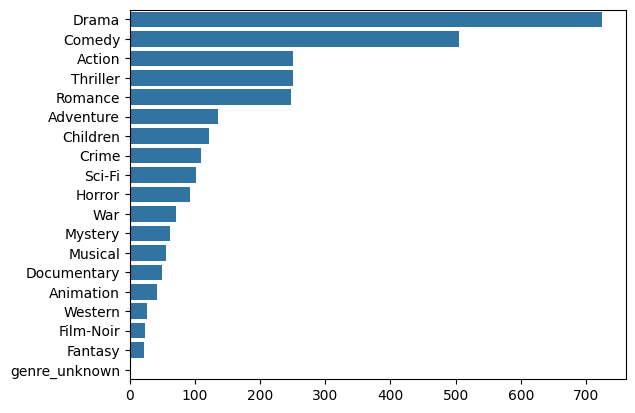

In [11]:
x = df.tolist()
y = df.index.tolist()
sns.barplot(x=x,y=y)

Disponemos de información relativa al contenido, pero es importante poder valorar qué películas son las mejor valoradas entre el público o cuales son las más populares (más vistas). Para ello deberemos cargar el tercer conjunto relevante para nuestro sistema de recomendación.

## Ratings

Finalmente, los ratings son los que recogen las impresiones de los usuarios con respecto a los ítems, dandonos la posibilidad de adecuar en base a dichos gustos la oferta a cada usuario.

In [12]:
# Cargamos las puntuaciones otorgadas por usuarios a películas vistas en un rango entre 1 a 5
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


Gracias a estos rating podremos, por ejemplo, buscar aquellas películas más populares.

In [13]:
titles = movies[['title', 'movie_id']]
df = pd.merge(ratings, titles, on='movie_id')
df.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

title
Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: rating, dtype: int64

Veremos que las películas más populares pueden no ser las mejor valoradas.

In [14]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
Aiqing wansui (1994)                                 5.0
Entertaining Angels: The Dorothy Day Story (1996)    5.0
Santa with Muscles (1996)                            5.0
Prefontaine (1997)                                   5.0
They Made Me a Criminal (1939)                       5.0
Saint of Fort Washington, The (1993)                 5.0
Great Day in Harlem, A (1994)                        5.0
Star Kid (1997)                                      5.0
Marlene Dietrich: Shadow and Light (1996)            5.0
Someone Else's America (1995)                        5.0
Name: rating, dtype: float64

Una vez conocemos nuestro conjunto de datos podemos plantearnos cómo deberían ser esas primeras recomendaciones a realizar.

## datos y expoortacion

In [15]:
df

,user_id,movie_id,rating,unix_timestamp,title
0,196,242,3.0,881250949,Kolya (1996)
1,186,302,3.0,891717742,L.A. Confidential (1997)
2,22,377,1.0,878887116,Heavyweights (1994)
3,244,51,2.0,880606923,Legends of the Fall (1994)
4,166,346,1.0,886397596,Jackie Brown (1997)
...,...,...,...,...,...
99995,880,476,3.0,880175444,"First Wives Club, The (1996)"
99996,716,204,5.0,879795543,Back to the Future (1985)
99997,276,1090,1.0,874795795,Sliver (1993)
99998,13,225,2.0,882399156,101 Dalmatians (1996)


In [16]:
data

,occupation,age
15,retired,63.071429
2,doctor,43.571429
3,educator,42.010526
7,healthcare,41.562500
10,librarian,40.000000
0,administrator,38.746835
6,executive,38.718750
11,marketing,37.615385
9,lawyer,36.750000
4,engineer,36.388060


In [17]:
users

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [18]:
movies

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1995
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1995
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1998
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1998
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1998
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1994


In [19]:
ratings

,user_id,movie_id,rating,unix_timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596
...,...,...,...,...
99995,880,476,3.0,880175444
99996,716,204,5.0,879795543
99997,276,1090,1.0,874795795
99998,13,225,2.0,882399156


In [20]:
df.to_csv("dfcl.csv")
data.to_csv("datacl.csv")
users.to_csv("userscl.csv")
movies.to_csv("moviescl.csv")
ratings.to_csv("ratingscl.csv")